# ProNDF Examples

This notebook contains examples for each dataset in the ProNDF codebase.

In [2]:
# Add src/ to sys.path so prondf imports work
import sys
from pathlib import Path

sys.path.insert(0, str(Path.cwd().parent / "src"))

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

from prondf import data, plotting
from prondf.data import collate_fn
from prondf.models import Build_ProNDF, ProNDF
from prondf.blocks import BLOCK_REGISTRY
from prondf.losses import LOSS_HANDLER_REGISTRY, LOSS_REGISTRY, DATA_SPLIT_REGISTRY, LW_ALG_REGISTRY
from prondf.optimizers import OPTIMIZER_REGISTRY
from prondf.loggers import (
    LossComponentsLogger, LossWeightsLogger, TruePredPlotLogger,
    LatentSpacePlotLogger, LearningRateLogger
)

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

c:\Users\tttam\anaconda3\envs\torch2\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


Using device: cuda


## 1. Rational Dataset

Load the rational dataset, scale it using min_max_normalizer to [0, 1], build a model with default arguments, fit it, and visualize results using plot_1D and plot_2D_latent_space for the source latent space.

In [ ]:
# Load rational dataset
dataset_path = "datasets/rational/generated_data"
train_dataset, val_dataset, test_dataset = data.load_splits(dataset_path, "rational_dataset")

# Scale data using min_max_normalizer to [0, 1]
# Fit on training data
scaler_num = data.MinMaxNormalizer(feature_range=(0.0, 1.0))
scaler_num.fit(train_dataset.num)

scaler_targets = data.MinMaxNormalizer(feature_range=(0.0, 1.0))
scaler_targets.fit(train_dataset.targets)

# Transform all datasets
train_dataset.num = scaler_num.transform(train_dataset.num)
train_dataset.targets = scaler_targets.transform(train_dataset.targets)

val_dataset.num = scaler_num.transform(val_dataset.num)
val_dataset.targets = scaler_targets.transform(val_dataset.targets)

test_dataset.num = scaler_num.transform(test_dataset.num)
test_dataset.targets = scaler_targets.transform(test_dataset.targets)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Val dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 95
Val dataset size: 57
Test dataset size: 15048


In [3]:
# Build model with default arguments
model = Build_ProNDF(
    dataset_meta=train_dataset.meta,
)

print("Model created successfully")

Model created successfully


In [4]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Train the model
trainer = pl.Trainer(
    max_epochs=100,
    accelerator='gpu' if device == 'cuda' else 'cpu',
    devices=1,
    enable_progress_bar=True,
    enable_model_summary=True,
)

trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type                      | Params
-----------------------------------------------------------
0 | B1           | Det_Block                 | 86    
1 | B3           | Prob_Block                | 1.3 K 
2 | loss_handler | Hierarchical_Loss_Handler | 0     
-----------------------------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimate

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\tttam\anaconda3\envs\torch2\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


c:\Users\tttam\anaconda3\envs\torch2\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\tttam\anaconda3\envs\torch2\Lib\site-packages\pytorch_lightning\trainer\trainer.py:1609: PossibleUserWarning: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 99: 100%|██████████| 5/5 [00:00<00:00, 43.06it/s, loss=17.4, v_num=3, train_loss_step=13.80, val_loss=11.70, train_loss_epoch=16.70]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 5/5 [00:00<00:00, 38.43it/s, loss=17.4, v_num=3, train_loss_step=13.80, val_loss=11.70, train_loss_epoch=16.70]


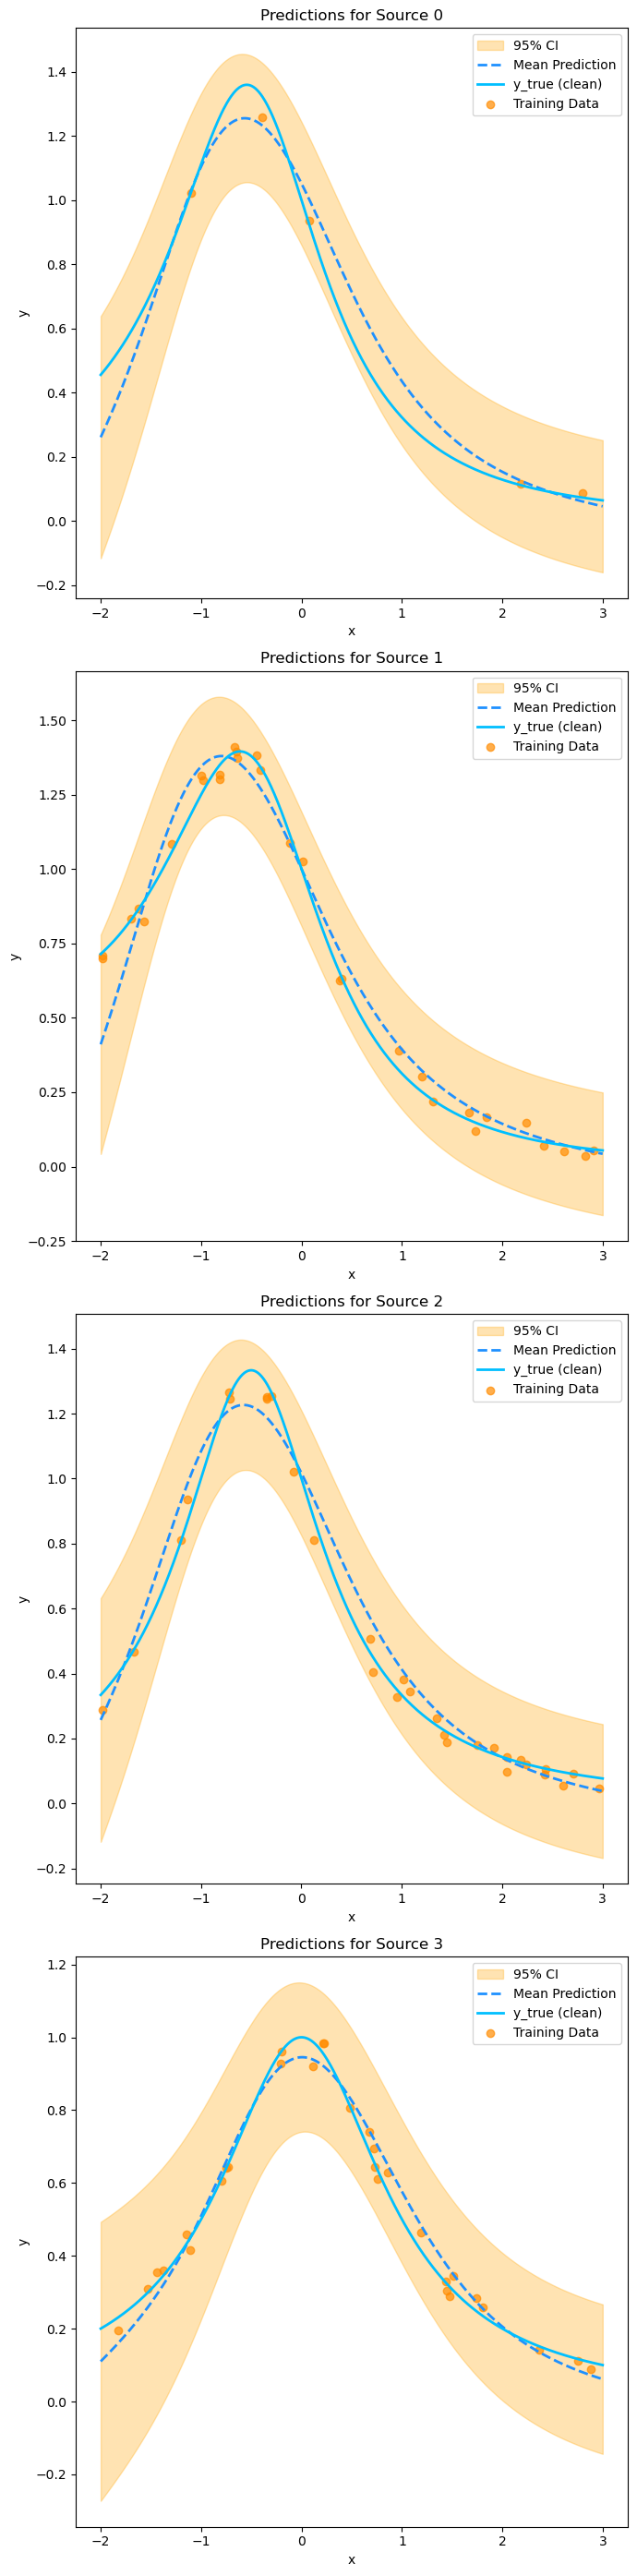

In [6]:
# Visualize results using plot_1D

# Set source functions
yh = lambda cat, x: 1.0 / ((0.1 * x[:] ** 3) + (x[:] ** 2) + x[:] + 1)
yl1 = lambda cat, x: 1.0 / ((0.2 * x[:] ** 3) + (x[:] ** 2) + x[:] + 1)
yl2 = lambda cat, x: 1.0 / ((x[:] ** 2) + x[:] + 1)
yl3 = lambda cat, x:  1.0 / ((x[:] ** 2)+ 1)
source_functions = [yh, yl1, yl2, yl3]

fig_1d = plotting.plot_1D(
    model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    scaler=scaler_num,  # For unscaling x-axis (numerical inputs)
    scaler_targets=scaler_targets,  # For unscaling y-axis (targets/predictions)
    device=device,
    batch_size=32,
    source_functions=source_functions,
    use_source_functions=True  # Enable clean target generation
)
plt.show()

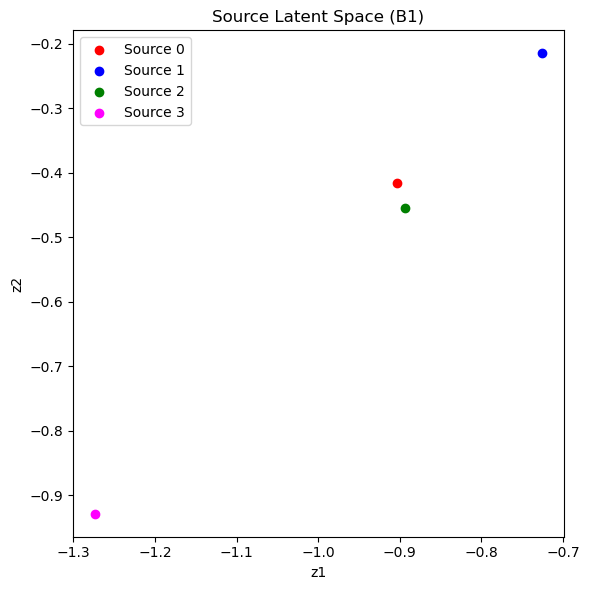

In [7]:
# Visualize source latent space using plot_2D_latent_space
fig_latent = plotting.plot_2D_latent_space(
    model=model,
    block_idx=0,  # Source latent space (B1)
    dcat=None,  # No categorical inputs
    device=device,
    figsize=6,
    num_iterations=100
)
plt.show()

## 2. Borehole Dataset

Load the borehole dataset, visualize data distributions, scale using standard_normalizer, and initialize/fit a model with custom configuration:
- Probabilistic output for block 1
- Probabilistic output for block 3
- One stage loss handler with output NLL loss and output IS loss regularizer
- Split by data source
- Two-moment weighting
- Log all loss components and loss weights
- Log both true-pred plots and latent space plots
- Use tensorboard logger

In [ ]:
# Load borehole dataset
dataset_path = "datasets/borehole/generated_data"
train_dataset, val_dataset, test_dataset = data.load_splits(dataset_path, "borehole_dataset")

print(f"Train dataset size: {len(train_dataset)}")
print(f"Val dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Number of features: {train_dataset.meta['dnum']}")
print(f"Number of sources: {train_dataset.meta['dsource']}")

Train dataset size: 215
Val dataset size: 86
Test dataset size: 29799
Number of features: 8
Number of sources: 5


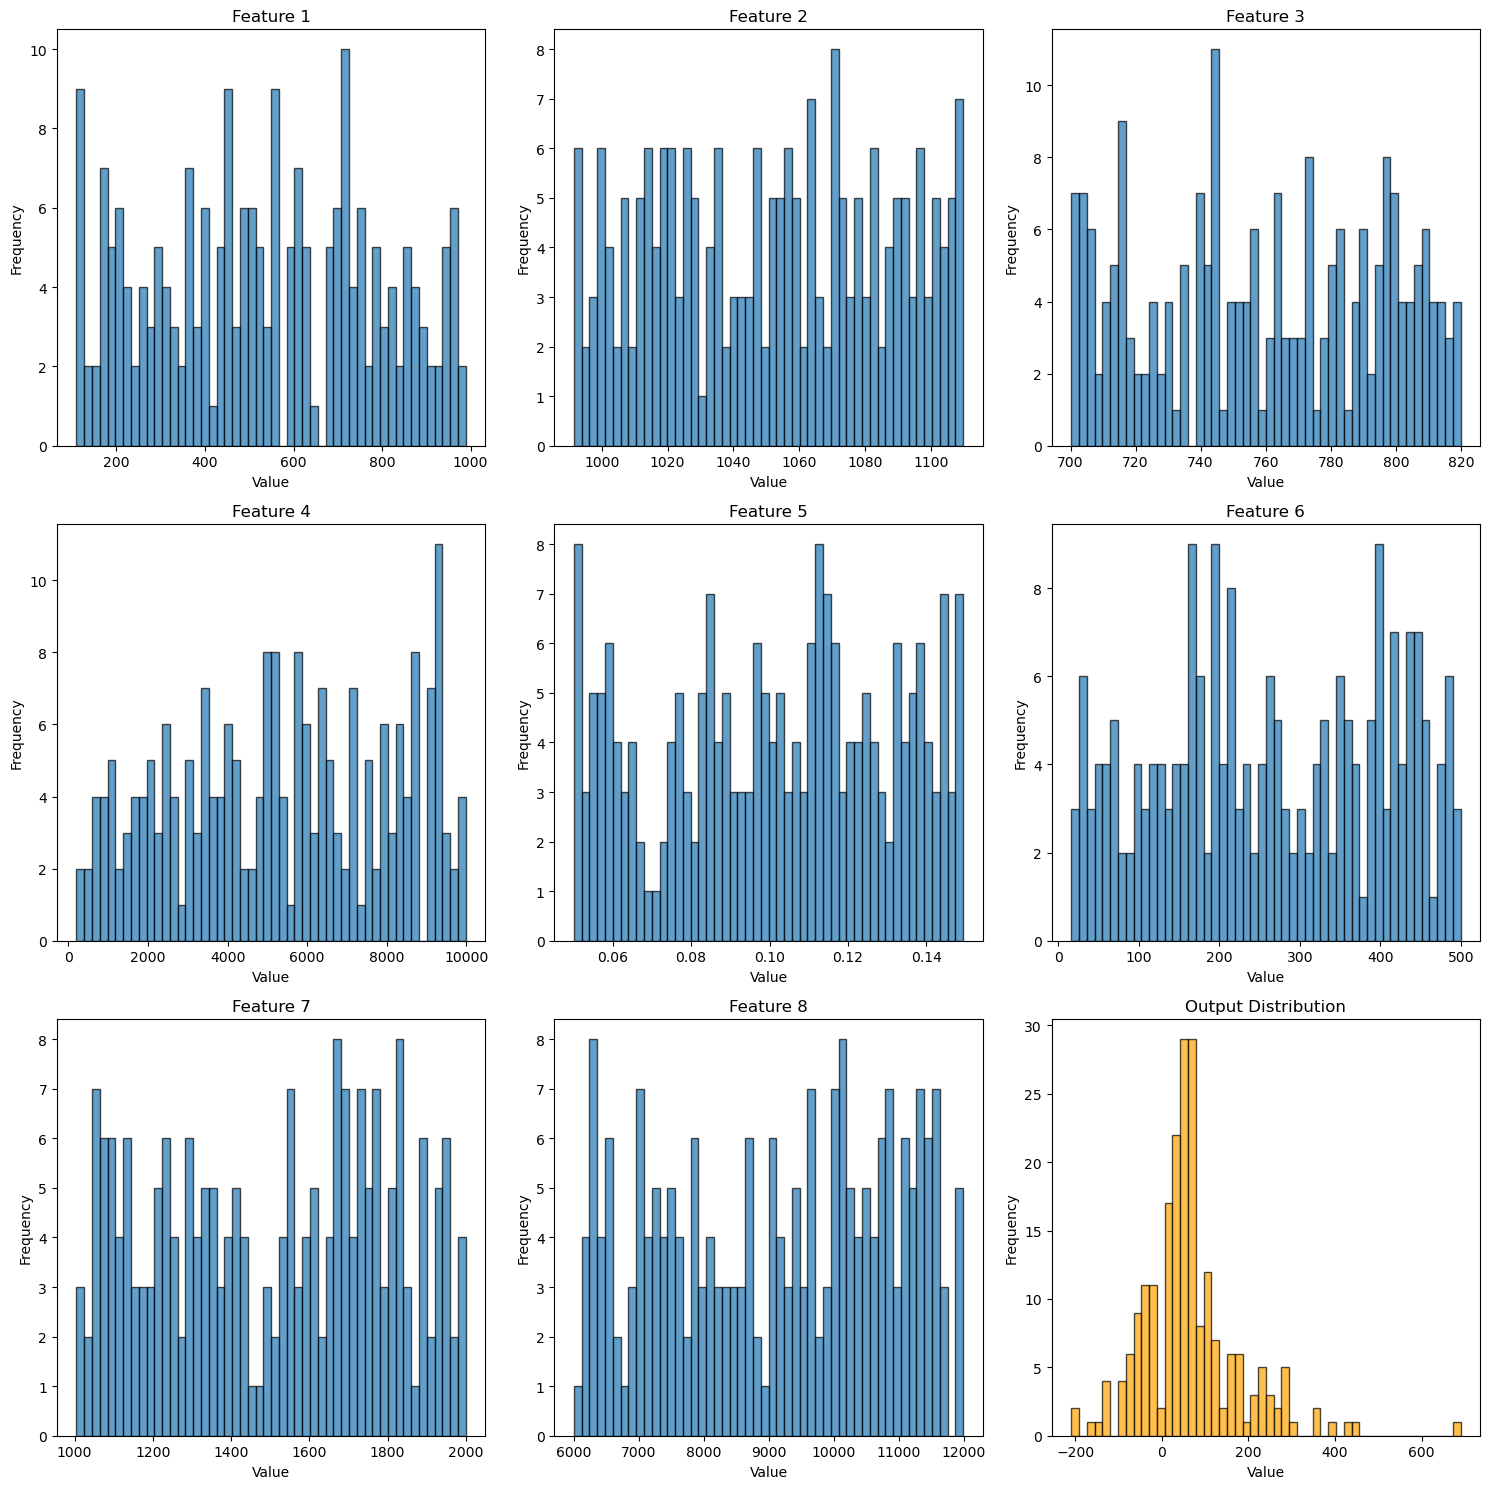

In [3]:
# Visualize data distributions using histograms
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

# Plot histograms for each feature
for i in range(train_dataset.meta['dnum']):
    axes[i].hist(train_dataset.num[:, i], bins=50, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'Feature {i+1}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# Plot histogram for output
axes[8].hist(train_dataset.targets.flatten(), bins=50, alpha=0.7, edgecolor='black', color='orange')
axes[8].set_title('Output Distribution')
axes[8].set_xlabel('Value')
axes[8].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [4]:
# Scale data using standard_normalizer
scaler_num = data.StandardNormalizer()
scaler_num.fit(train_dataset.num)

scaler_targets = data.StandardNormalizer()
scaler_targets.fit(train_dataset.targets)

# Transform all datasets
train_dataset.num = scaler_num.transform(train_dataset.num)
train_dataset.targets = scaler_targets.transform(train_dataset.targets)

val_dataset.num = scaler_num.transform(val_dataset.num)
val_dataset.targets = scaler_targets.transform(val_dataset.targets)

test_dataset.num = scaler_num.transform(test_dataset.num)
test_dataset.targets = scaler_targets.transform(test_dataset.targets)

print("Data scaled using standard normalizer")

Data scaled using standard normalizer


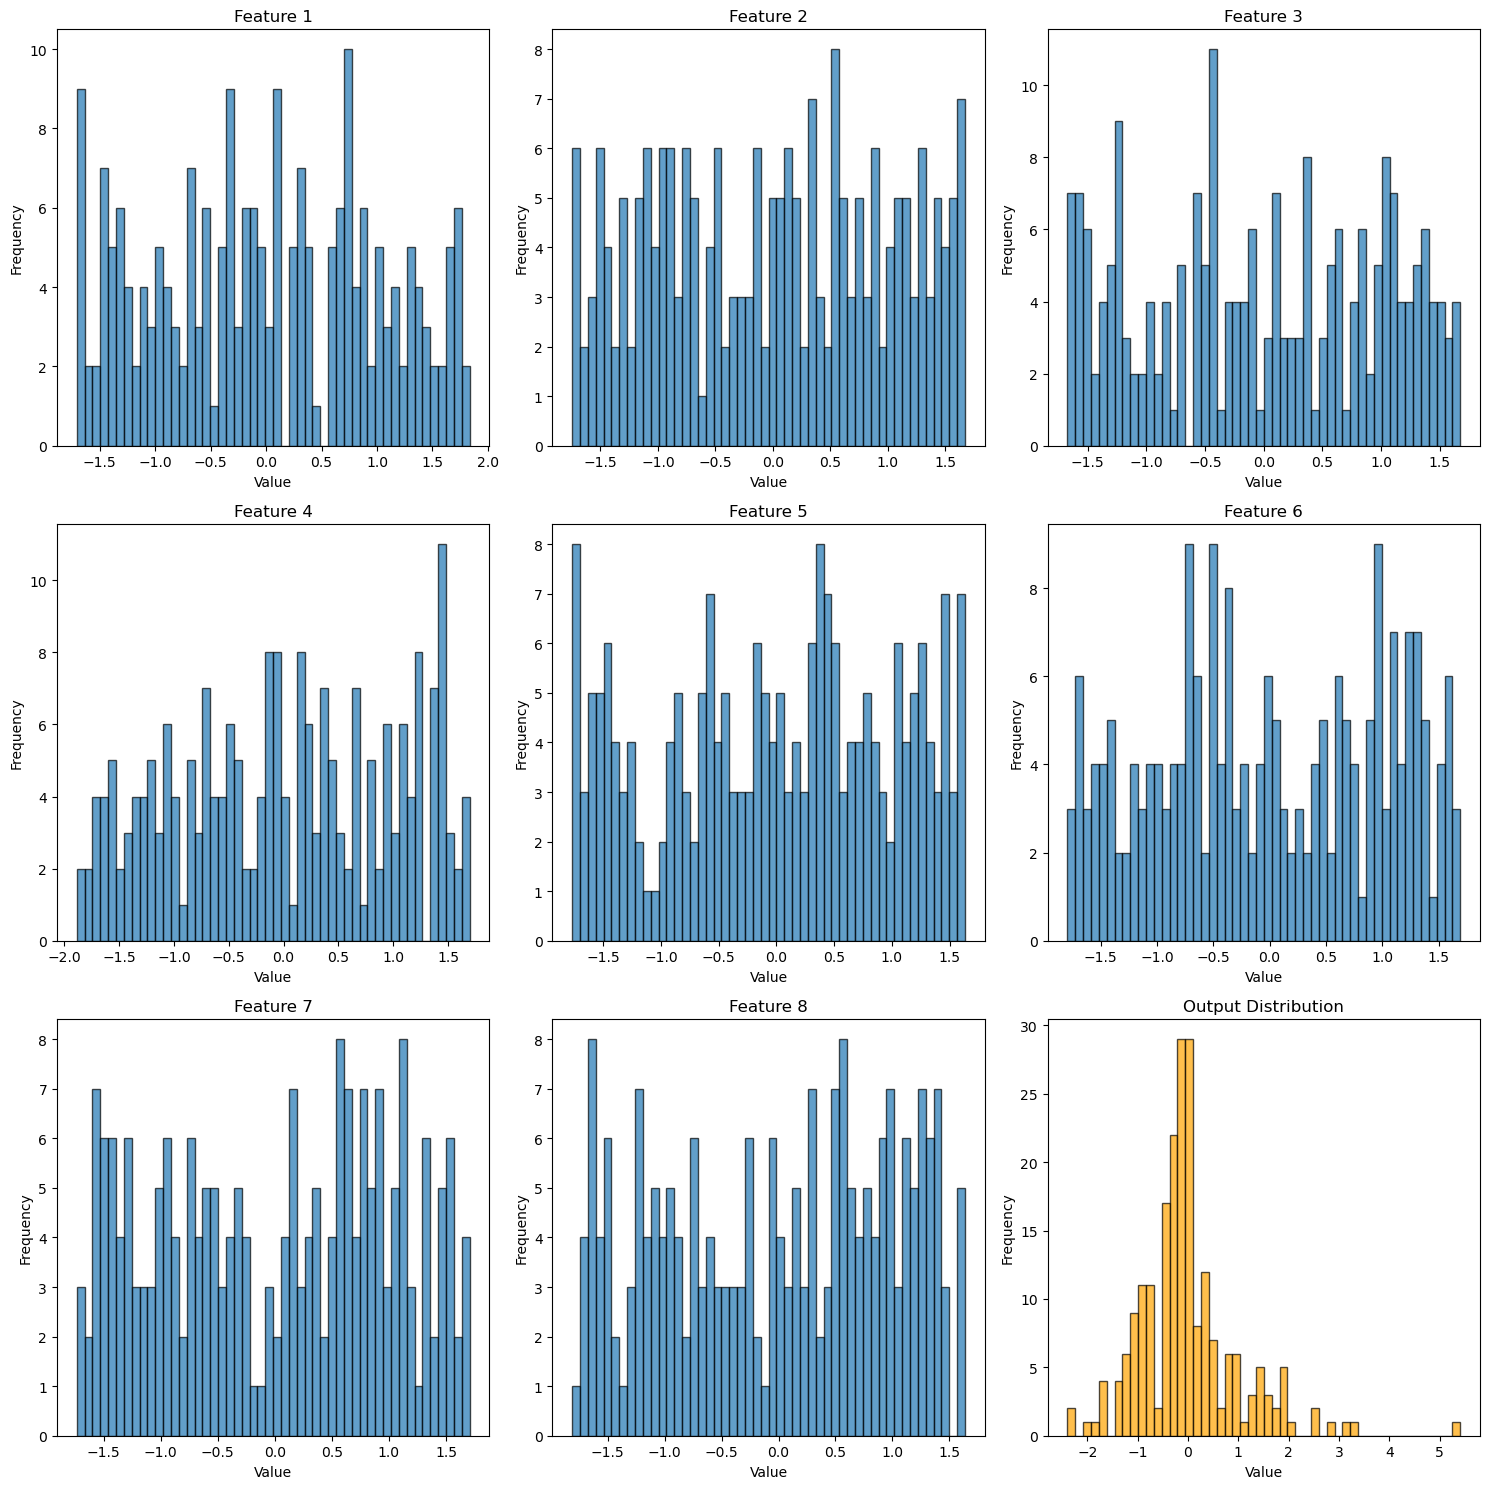

In [5]:
# Visualize data distributions using histograms after scaling
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

# Plot histograms for each feature
for i in range(train_dataset.meta['dnum']):
    axes[i].hist(train_dataset.num[:, i], bins=50, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'Feature {i+1}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# Plot histogram for output
axes[8].hist(train_dataset.targets.flatten(), bins=50, alpha=0.7, edgecolor='black', color='orange')
axes[8].set_title('Output Distribution')
axes[8].set_xlabel('Value')
axes[8].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [6]:
# Initialize model with custom configuration (not using default constructor)
# Get data parameters
dsource = train_dataset.meta['dsource']
dcat = train_dataset.meta.get('dcat', [])
dnum = train_dataset.meta['dnum']
dout = train_dataset.meta['dtargets']
qual_in = train_dataset.meta['qual_in']
quant_in = train_dataset.meta['quant_in']

# Block configurations
# Block 1: Probabilistic block
B1_type = "Prob_Block"
B1_config = {
    "d_in": dsource,
    "d_out": 2,
    "hidden_layers": [8, 4],
    "hidden_act_fn": "Tanh",
    "output_act_fn": "Identity",
}

# Block 3: Probabilistic block
d_u = 2 + dnum  # dz_B1 + dnum
B3_type = "Prob_Block"
B3_config = {
    "d_in": d_u,
    "d_out": dout,
    "hidden_layers": [16, 32, 16, 8],
    "hidden_act_fn": "Tanh",
    "output_act_fn": "Identity",
}

# Loss handler configuration: One stage with output NLL loss, output IS loss regularizer,
# split by source, two-moment weighting
loss_handler_type = "One_Stage_Loss_Handler"
loss_handler_config = {
    "loss_function_classes": ["Output_NLL_loss"],
    "loss_function_configs": [{}],
    "data_split_classes": ["Split_by_Source"],
    "data_split_configs": [{"num_sources": dsource}],
    "LW_alg_classes": ["Two_Moment_Weighting"],
    "LW_alg_configs": [{"num_loss_terms": dsource}],  # Will be updated by handler
    "regularizer_classes": ["Output_IS_loss"],
    "regularizer_configs": [{"alpha": 0.05, "strength": 0.1}],
}

# Optimizer configuration
optimizer_type = "Adam"
optimizer_config = {
    "lr": 0.001,
    "weight_decay": 0.001,
}

# Loggers: loss components, loss weights, true-pred plots, latent space plots
loggers = [
    LossComponentsLogger(log_prefix="train", log_individual_terms=True),
    LossWeightsLogger(log_prefix="train", log_individual_weights=True),
    TruePredPlotLogger(
        dataset=val_dataset,
        log_prefix="val",
        log_frequency=5,
        log_on_stage="val",
        device=device,
        batch_size=32
    ),
    LatentSpacePlotLogger(
        block_idx=0,  # Source latent space
        log_prefix="val",
        log_frequency=5,
        log_on_stage="val",
        device=device,
        figsize=6
    ),
]

# Build model
model = ProNDF(
    dsource=dsource,
    dcat=dcat,
    dnum=dnum,
    dout=dout,
    qual_in=qual_in,
    quant_in=quant_in,
    B1_type=B1_type,
    B1_config=B1_config,
    B2_type="Det_Block",  # Not used but required
    B2_config={"d_in": 0, "d_out": 2, "hidden_layers": [8, 4], "hidden_act_fn": "Tanh", "output_act_fn": "Identity"},
    B3_type=B3_type,
    B3_config=B3_config,
    loss_handler_type=loss_handler_type,
    loss_handler_config=loss_handler_config,
    optimizer_type=optimizer_type,
    optimizer_config=optimizer_config,
    loggers=loggers,
)

print("Model created with custom configuration")

Model created with custom configuration


In [7]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Create TensorBoard logger
tb_logger = TensorBoardLogger(
    save_dir="./logs",
    name="borehole_example",
    version=0
)

# Train the model
trainer = pl.Trainer(
    max_epochs=100,
    accelerator='gpu' if device == 'cuda' else 'cpu',
    devices=1,
    enable_progress_bar=True,
    enable_model_summary=True,
    logger=tb_logger,  # Required for custom loggers
)

trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type                   | Params
--------------------------------------------------------
0 | B1           | Prob_Block             | 104   
1 | B3           | Prob_Block             | 1.4 K 
2 | loss_handler | One_Stage_Loss_Handler | 0     
--------------------------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params siz

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\tttam\anaconda3\envs\torch2\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\tttam\Documents\Tammer\Projects\git_repos\ProNDF\loggers.py:570: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_numpy.cpp:212.)
  img_tensor = torch.from_numpy(buf).permute(2, 0, 1).float() / 255.0


c:\Users\tttam\anaconda3\envs\torch2\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\tttam\anaconda3\envs\torch2\Lib\site-packages\pytorch_lightning\trainer\trainer.py:1609: PossibleUserWarning: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 19.51it/s, loss=40.7, v_num=0, train_loss_step=0.0799, val_loss=1.860, train_loss_epoch=37.80]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 10/10 [00:00<00:00, 18.99it/s, loss=40.7, v_num=0, train_loss_step=0.0799, val_loss=1.860, train_loss_epoch=37.80]


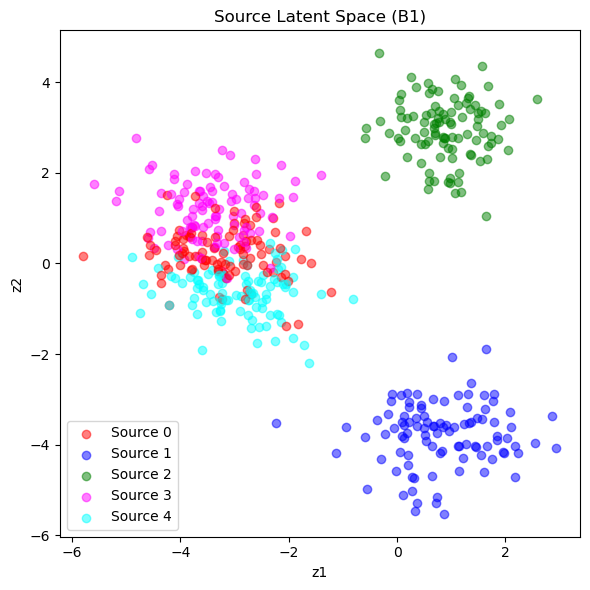

In [8]:
# Visualize latent space
fig_latent = plotting.plot_2D_latent_space(
    model=model,
    block_idx=0,  # Source latent space (B1)
    dcat=None,
    device=device,
    figsize=6,
    num_iterations=100
)
plt.show()

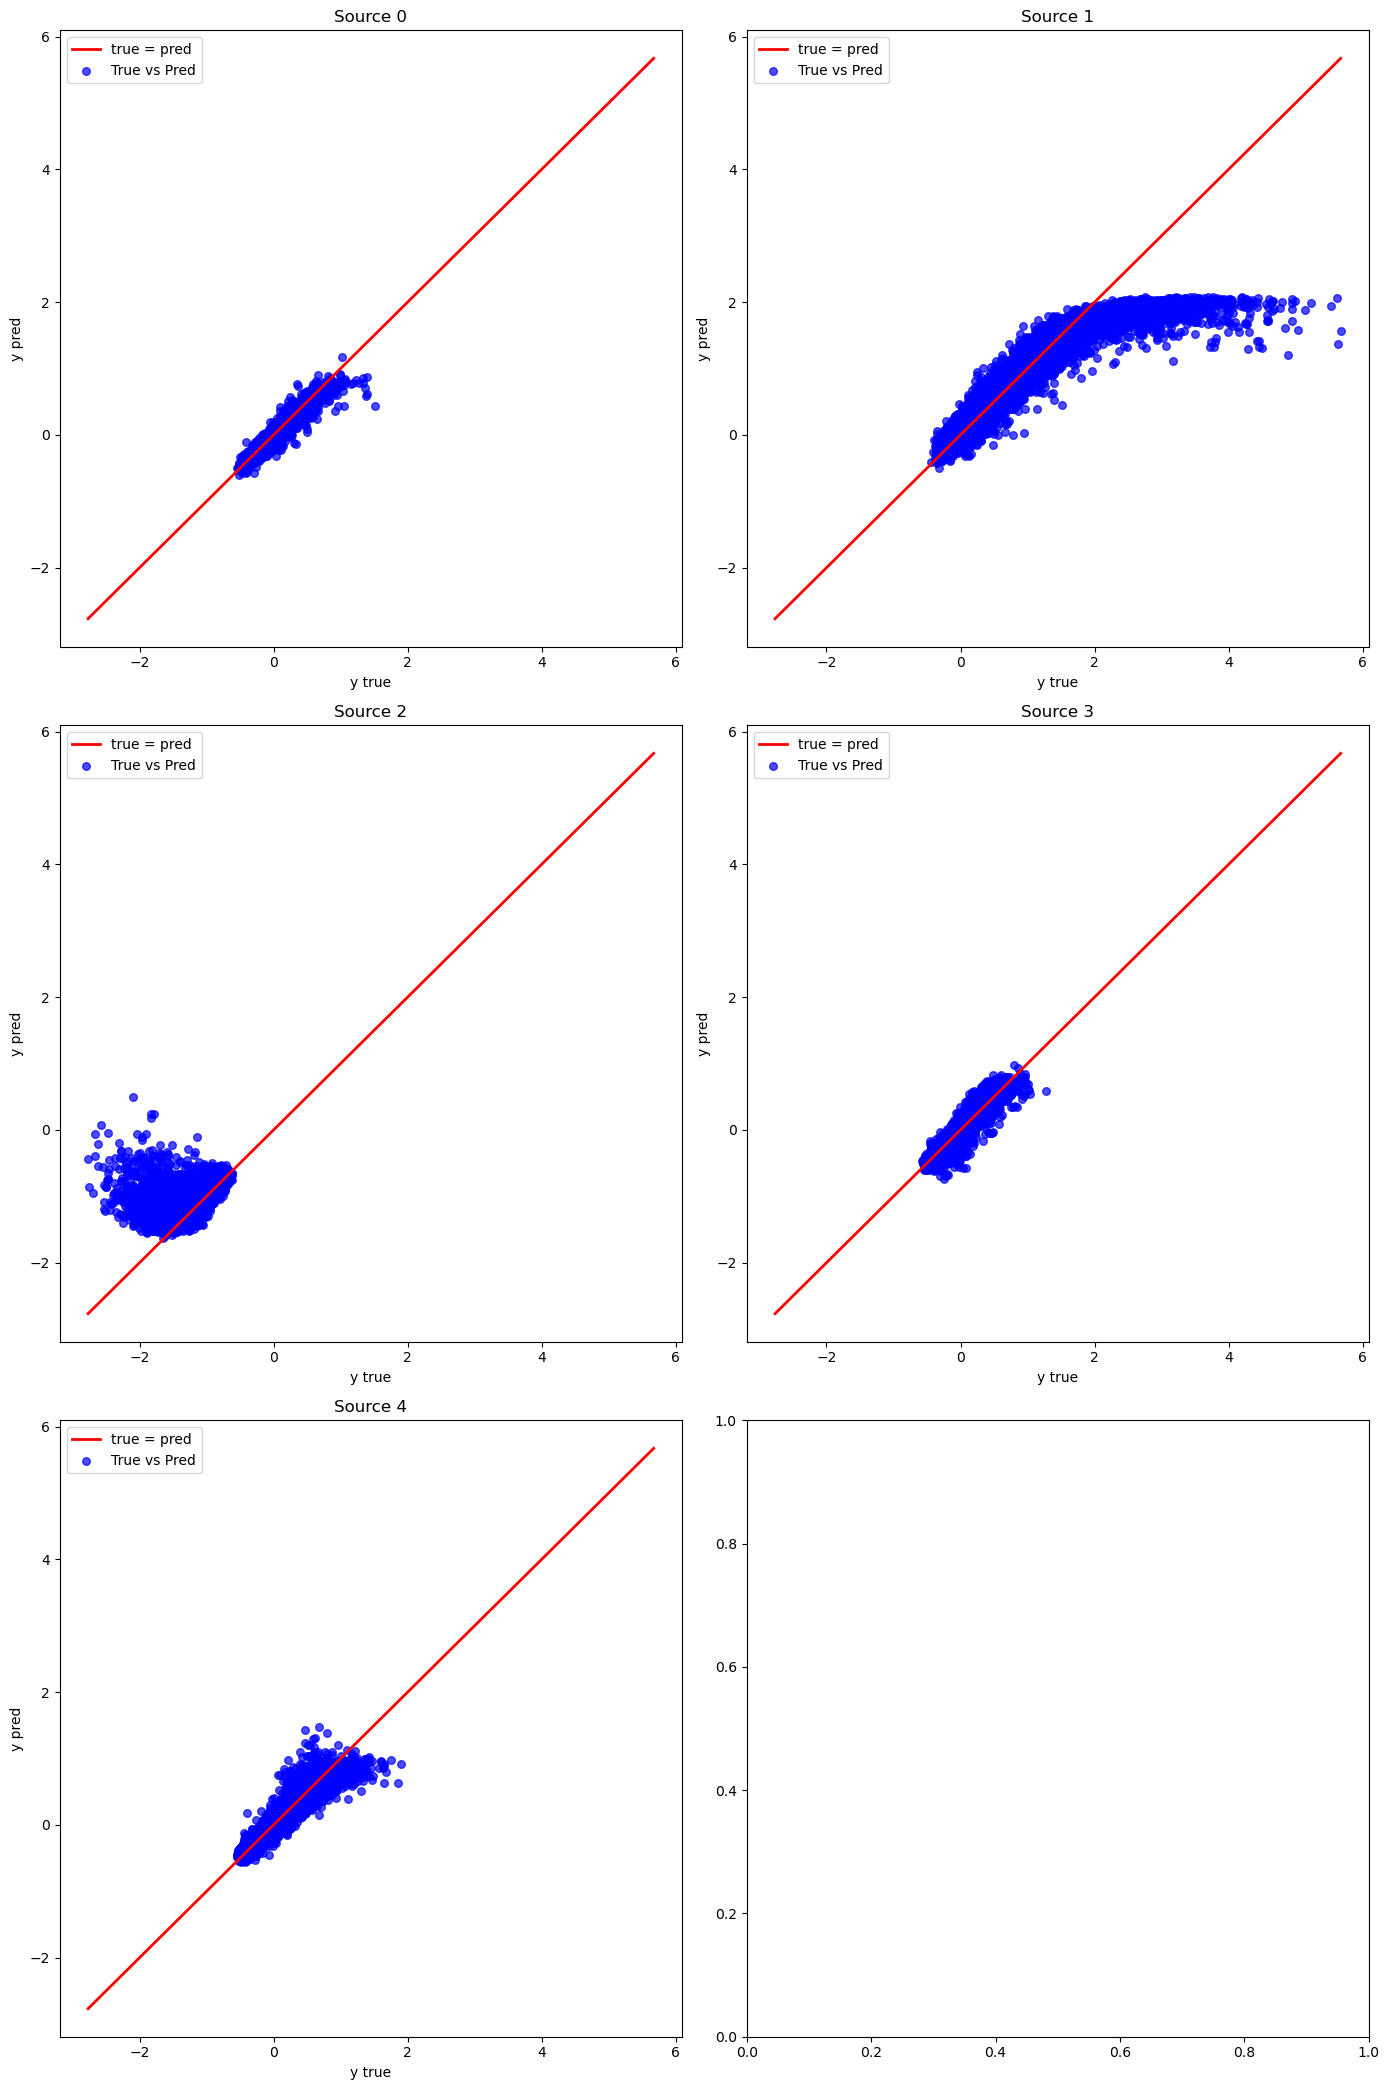

In [9]:
# Visualize true-pred plot

fig_true_pred = plotting.plot_true_pred(
    model=model,
    test_dataset=test_dataset,
    device=device,
    batch_size=32,
)
plt.show()

## 3. Wing-Weight Dataset

Load the wing-weight dataset, visualize data distributions, scale using standard_normalizer, initialize and fit a model using the constructor with default arguments except for plot logging (latent space and true-pred plots), and visualize results.

In [ ]:
# Load wing-weight dataset
dataset_path = "datasets/wing_weight/generated_data"
train_dataset, val_dataset, test_dataset = data.load_splits(dataset_path, "wing_weight_dataset")

print(f"Train dataset size: {len(train_dataset)}")
print(f"Val dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Number of features: {train_dataset.meta['dnum']}")
print(f"Number of sources: {train_dataset.meta['dsource']}")

Train dataset size: 165
Val dataset size: 66
Test dataset size: 22869
Number of features: 10
Number of sources: 4


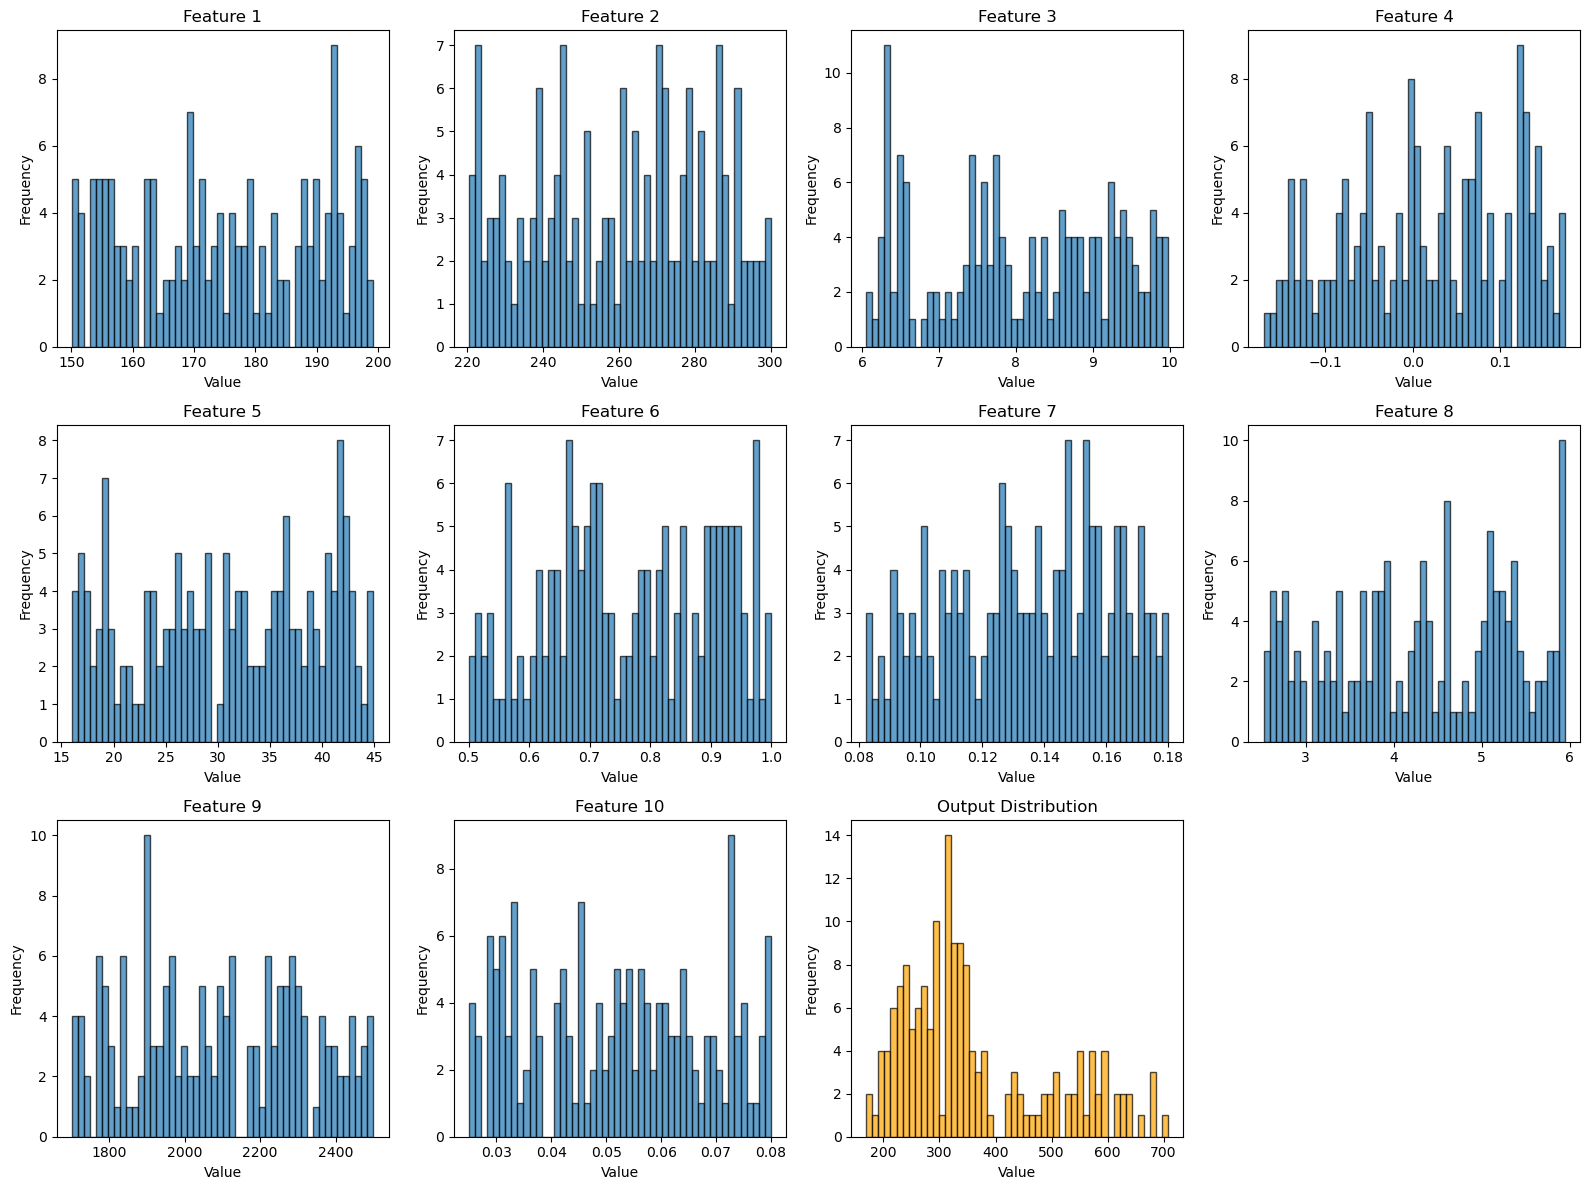

In [11]:
# Visualize data distributions using histograms
n_features = train_dataset.meta['dnum']
n_cols = 4
n_rows = int(np.ceil((n_features + 1) / n_cols))  # +1 for output

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
axes = axes.flatten()

# Plot histograms for each feature
for i in range(n_features):
    axes[i].hist(train_dataset.num[:, i], bins=50, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'Feature {i+1}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# Plot histogram for output
axes[n_features].hist(train_dataset.targets.flatten(), bins=50, alpha=0.7, edgecolor='black', color='orange')
axes[n_features].set_title('Output Distribution')
axes[n_features].set_xlabel('Value')
axes[n_features].set_ylabel('Frequency')

# Hide unused subplots
for i in range(n_features + 1, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [12]:
# Scale data using standard_normalizer
scaler_num = data.StandardNormalizer()
scaler_num.fit(train_dataset.num)

scaler_targets = data.StandardNormalizer()
scaler_targets.fit(train_dataset.targets)

# Transform all datasets
train_dataset.num = scaler_num.transform(train_dataset.num)
train_dataset.targets = scaler_targets.transform(train_dataset.targets)

val_dataset.num = scaler_num.transform(val_dataset.num)
val_dataset.targets = scaler_targets.transform(val_dataset.targets)

test_dataset.num = scaler_num.transform(test_dataset.num)
test_dataset.targets = scaler_targets.transform(test_dataset.targets)

print("Data scaled using standard normalizer")

Data scaled using standard normalizer


In [13]:
# Build model using constructor with default arguments except for plot logging
loggers = [
    LearningRateLogger(),
    TruePredPlotLogger(
        dataset=val_dataset,
        log_prefix="val",
        log_frequency=5,
        log_on_stage="val",
        device=device,
        batch_size=32
    ),
    LatentSpacePlotLogger(
        block_idx=0,  # Source latent space
        log_prefix="val",
        log_frequency=5,
        log_on_stage="val",
        device=device,
        figsize=6
    ),
]

model = Build_ProNDF(
    dataset_meta=train_dataset.meta,
    loggers=loggers,
)

print("Model created successfully")

Model created successfully


In [14]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Create TensorBoard logger
tb_logger = TensorBoardLogger(
    save_dir="./logs",
    name="wing_weight_example",
    version=0
)

# Train the model
trainer = pl.Trainer(
    max_epochs=100,
    accelerator='gpu' if device == 'cuda' else 'cpu',
    devices=1,
    enable_progress_bar=True,
    enable_model_summary=True,
    logger=tb_logger,
)

trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type                      | Params
-----------------------------------------------------------
0 | B1           | Det_Block                 | 86    
1 | B3           | Prob_Block                | 1.4 K 
2 | loss_handler | Hierarchical_Loss_Handler | 0     
-----------------------------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimate

c:\Users\tttam\anaconda3\envs\torch2\Lib\site-packages\pytorch_lightning\trainer\trainer.py:1609: PossibleUserWarning: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 99: 100%|██████████| 9/9 [00:00<00:00, 43.02it/s, loss=15, v_num=0, train_loss_step=8.600, val_loss=23.40, train_loss_epoch=16.20]  

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 9/9 [00:00<00:00, 41.25it/s, loss=15, v_num=0, train_loss_step=8.600, val_loss=23.40, train_loss_epoch=16.20]


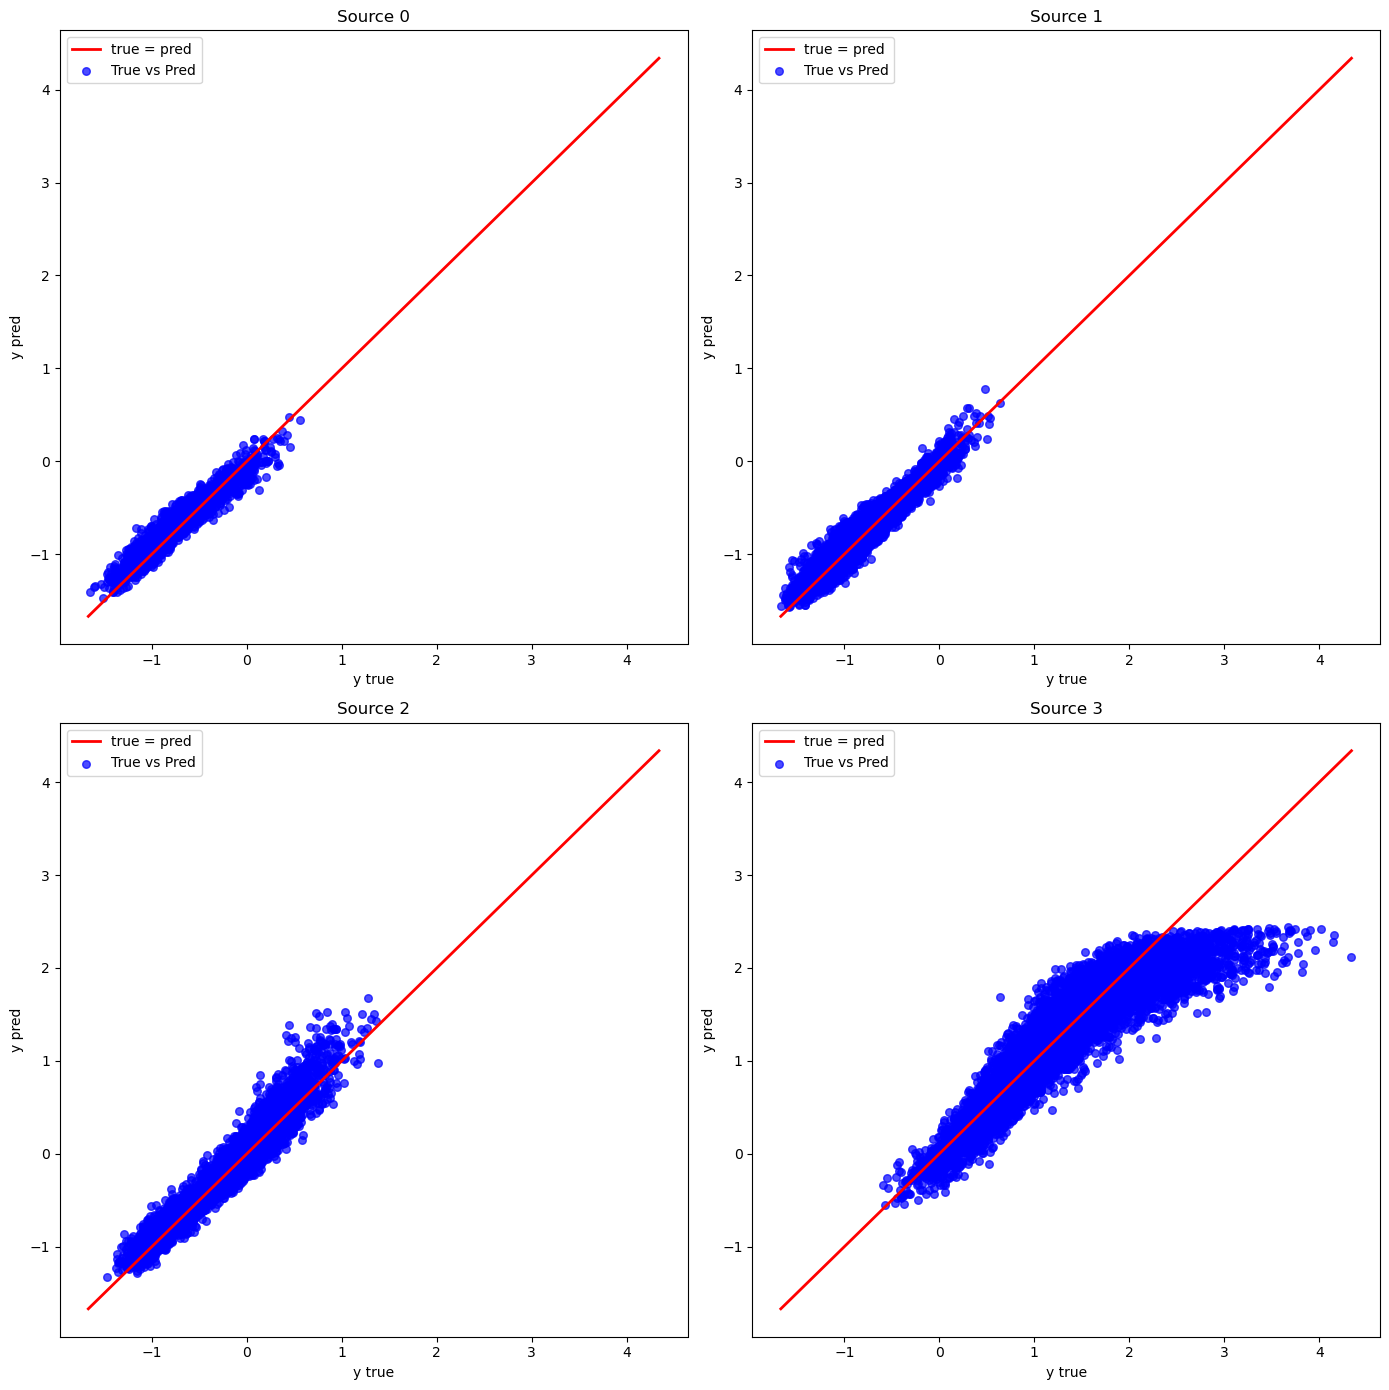

In [15]:
# Visualize true-pred plot
fig_true_pred = plotting.plot_true_pred(
    model=model,
    test_dataset=test_dataset,
    device=device,
    batch_size=32
)
plt.show()

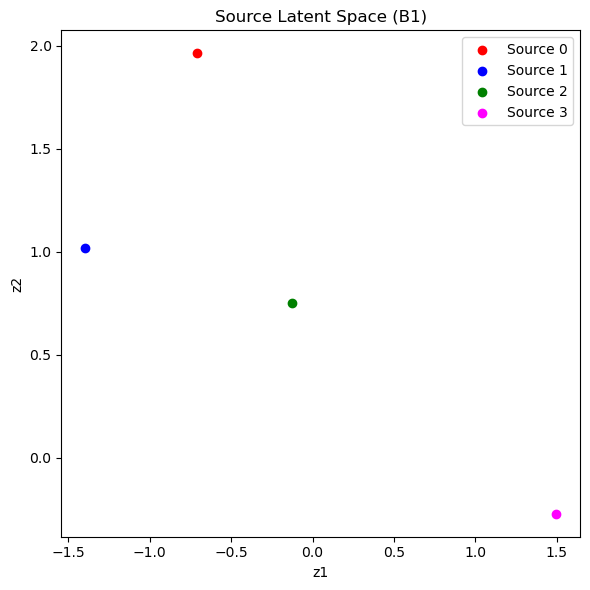

In [16]:
# Visualize latent space
fig_latent = plotting.plot_2D_latent_space(
    model=model,
    block_idx=0,  # Source latent space (B1)
    dcat=None,
    device=device,
    figsize=6,
    num_iterations=100
)
plt.show()

## 4. DNS-ROM Dataset

Load the DNS-ROM dataset, visualize data distributions, initialize and fit a model using the constructor with default arguments except for plot logging (latent space and true-pred plots), and visualize results.

In [ ]:
# Load DNS-ROM dataset
dataset_path = "datasets/DNS_ROM/generated_data"
train_dataset, val_dataset, test_dataset = data.load_splits(dataset_path, "DNS_ROM_dataset")

print(f"Train dataset size: {len(train_dataset)}")
print(f"Val dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Number of features: {train_dataset.meta['dnum']}")
print(f"Number of sources: {train_dataset.meta['dsource']}")

Train dataset size: 431
Val dataset size: 49
Test dataset size: 120
Number of features: 6
Number of sources: 4


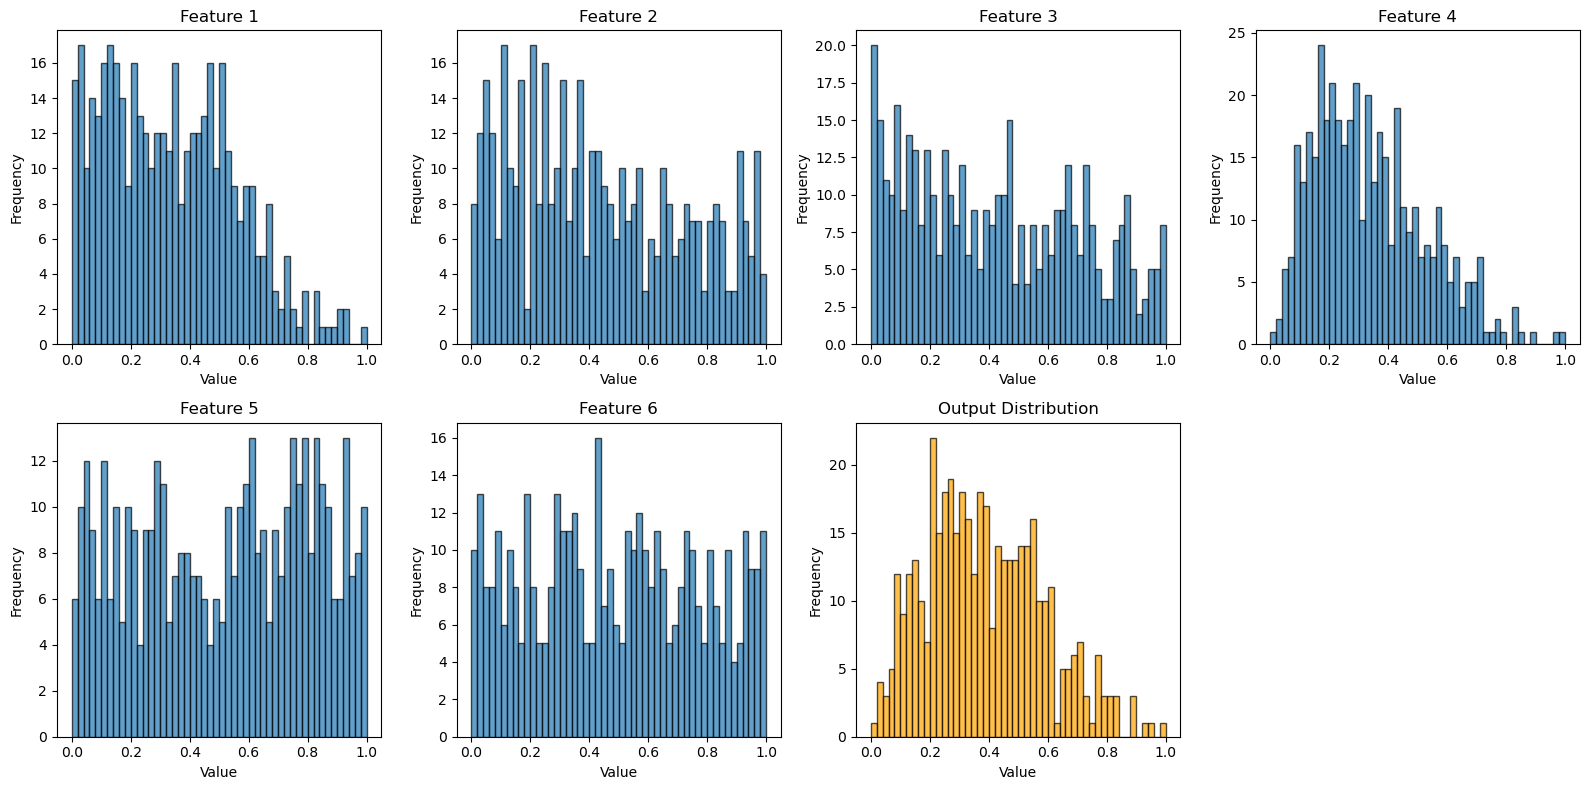

In [18]:
# Visualize data distributions using histograms
n_features = train_dataset.meta['dnum']
n_cols = 4
n_rows = int(np.ceil((n_features + 1) / n_cols))  # +1 for output

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
axes = axes.flatten()

# Plot histograms for each feature
for i in range(n_features):
    axes[i].hist(train_dataset.num[:, i], bins=50, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'Feature {i+1}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# Plot histogram for output
axes[n_features].hist(train_dataset.targets.flatten(), bins=50, alpha=0.7, edgecolor='black', color='orange')
axes[n_features].set_title('Output Distribution')
axes[n_features].set_xlabel('Value')
axes[n_features].set_ylabel('Frequency')

# Hide unused subplots
for i in range(n_features + 1, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [19]:
# Build model using constructor with default arguments except for plot logging
loggers = [
    LearningRateLogger(),
    TruePredPlotLogger(
        dataset=val_dataset,
        log_prefix="val",
        log_frequency=5,
        log_on_stage="val",
        device=device,
        batch_size=32
    ),
    LatentSpacePlotLogger(
        block_idx=0,  # Source latent space
        log_prefix="val",
        log_frequency=5,
        log_on_stage="val",
        device=device,
        figsize=6
    ),
]

model = Build_ProNDF(
    dataset_meta=train_dataset.meta,
    loggers=loggers,
)

print("Model created successfully")

Model created successfully


In [20]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Create TensorBoard logger
tb_logger = TensorBoardLogger(
    save_dir="./logs",
    name="DNS_ROM_example",
    version=0
)

# Train the model
trainer = pl.Trainer(
    max_epochs=100,
    accelerator='gpu' if device == 'cuda' else 'cpu',
    devices=1,
    enable_progress_bar=True,
    enable_model_summary=True,
    logger=tb_logger,
)

trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type                      | Params
-----------------------------------------------------------
0 | B1           | Det_Block                 | 86    
1 | B3           | Prob_Block                | 1.4 K 
2 | loss_handler | Hierarchical_Loss_Handler | 0     
-----------------------------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimate

c:\Users\tttam\anaconda3\envs\torch2\Lib\site-packages\pytorch_lightning\trainer\trainer.py:1609: PossibleUserWarning: The number of training batches (14) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 99: 100%|██████████| 16/16 [00:00<00:00, 42.86it/s, loss=13.3, v_num=0, train_loss_step=9.150, val_loss=10.60, train_loss_epoch=13.30]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 16/16 [00:00<00:00, 41.85it/s, loss=13.3, v_num=0, train_loss_step=9.150, val_loss=10.60, train_loss_epoch=13.30]


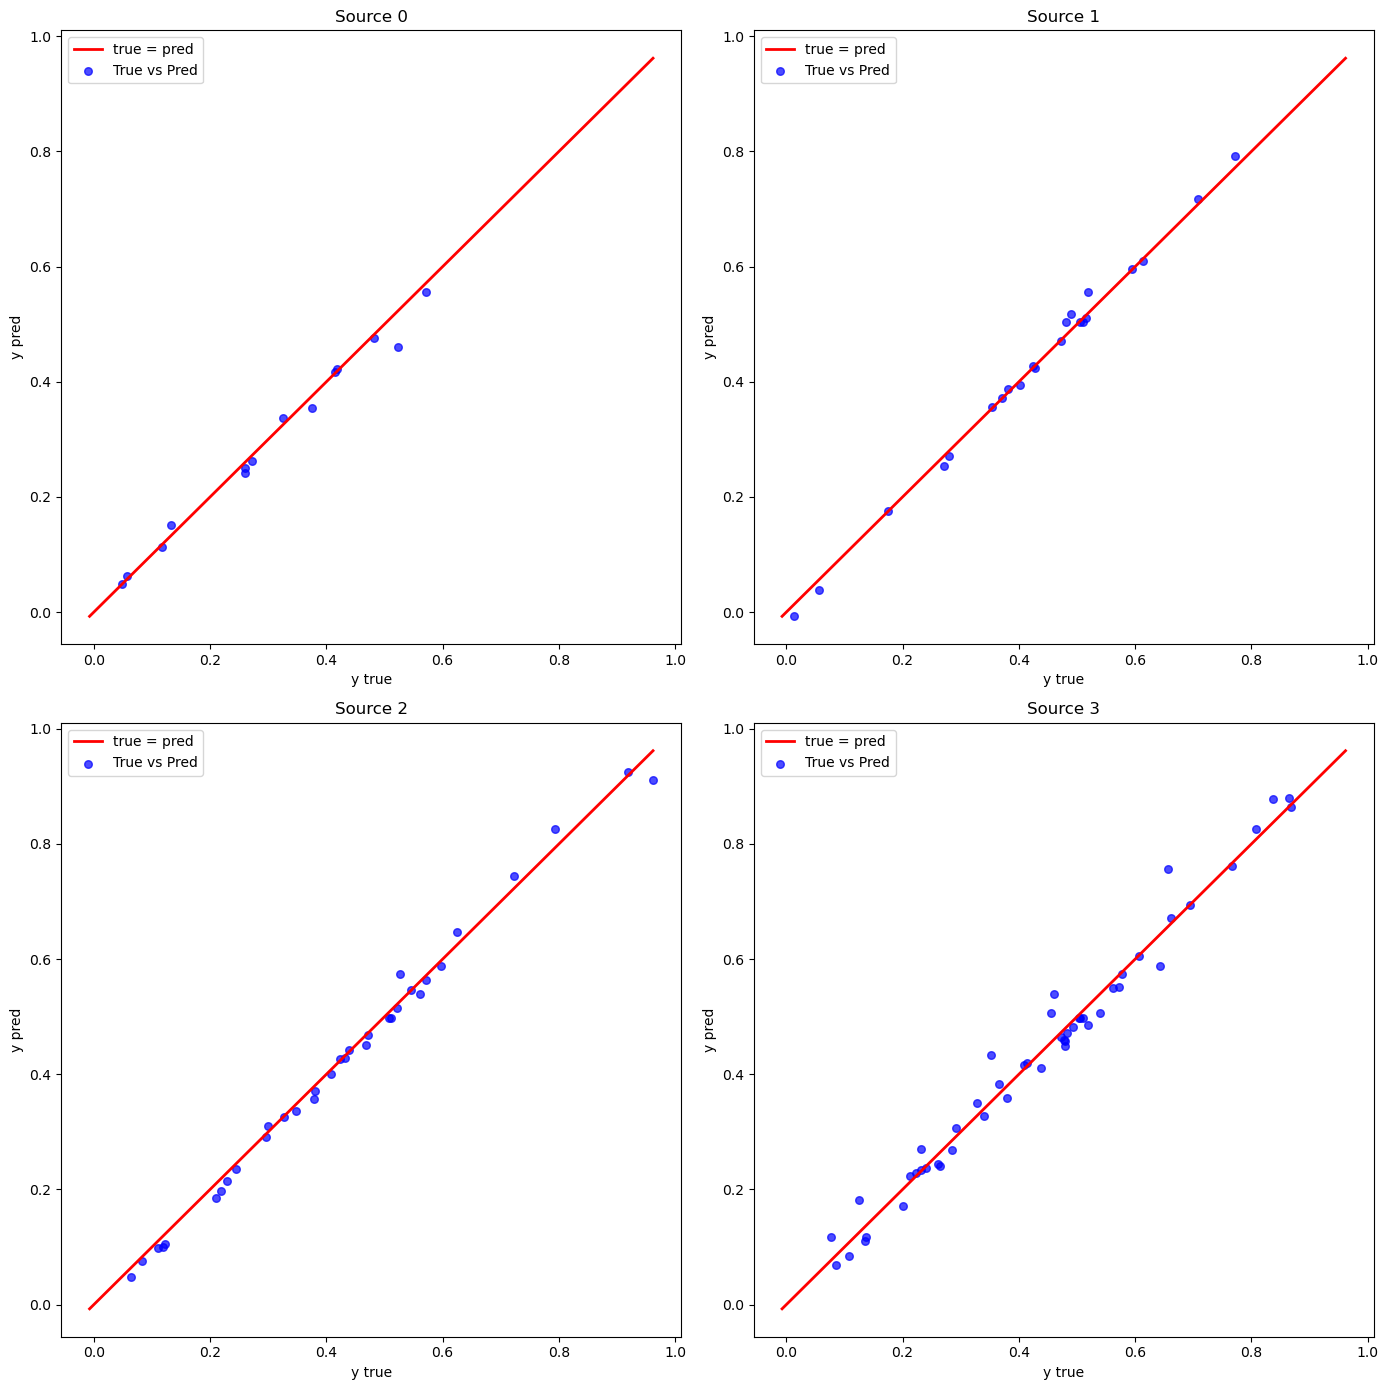

In [21]:
# Visualize true-pred plot
fig_true_pred = plotting.plot_true_pred(
    model=model,
    test_dataset=test_dataset,
    device=device,
    batch_size=32
)
plt.show()

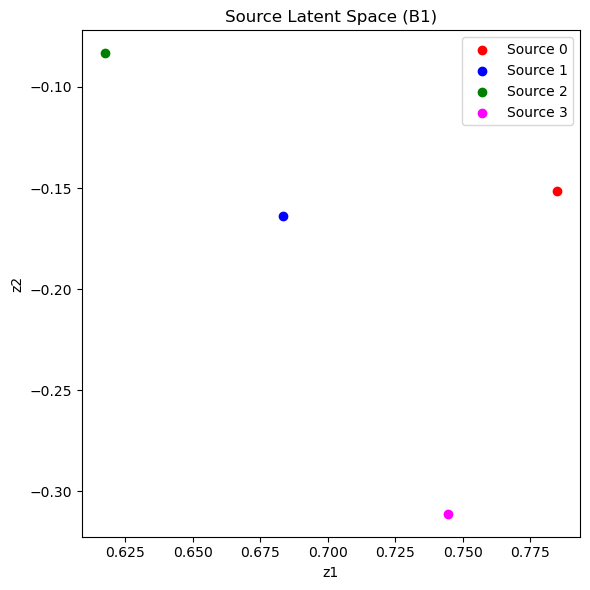

In [22]:
# Visualize latent space
fig_latent = plotting.plot_2D_latent_space(
    model=model,
    block_idx=0,  # Source latent space (B1)
    dcat=None,
    device=device,
    figsize=6,
    num_iterations=100
)
plt.show()

## 5. HOIP Dataset

Load the HOIP dataset, visualize the output distribution, initialize and fit a model using the constructor with default arguments except for plot logging (latent space and true-pred plots), and visualize results.

In [ ]:
# Load HOIP dataset
dataset_path = "datasets/HOIP/generated_data"
train_dataset, val_dataset, test_dataset = data.load_splits(dataset_path, "HOIP_dataset")

print(f"Train dataset size: {len(train_dataset)}")
print(f"Val dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"Number of sources: {train_dataset.meta['dsource']}")
print(f"Has categorical inputs: {train_dataset.meta['qual_in']}")
print(f"Has numerical inputs: {train_dataset.meta['quant_in']}")

Train dataset size: 1103
Val dataset size: 138
Test dataset size: 138
Number of sources: 4
Has categorical inputs: True
Has numerical inputs: False


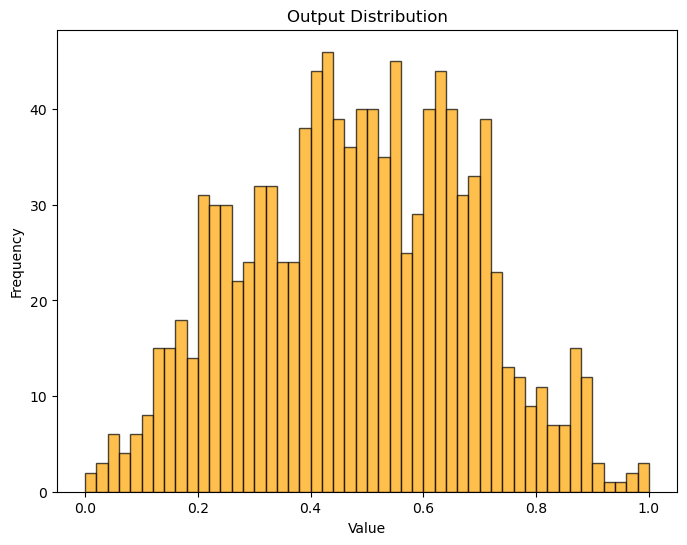

In [5]:
# Visualize output distribution with histogram
plt.figure(figsize=(8, 6))
plt.hist(train_dataset.targets.flatten(), bins=50, alpha=0.7, edgecolor='black', color='orange')
plt.title('Output Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [6]:
# Build model using constructor with default arguments except for plot logging
loggers = [
    LearningRateLogger(),
    TruePredPlotLogger(
        dataset=val_dataset,
        log_prefix="val",
        log_frequency=5,
        log_on_stage="val",
        device=device,
        batch_size=32
    ),
    LatentSpacePlotLogger(
        block_idx=0,  # Source latent space
        log_prefix="val",
        log_frequency=5,
        log_on_stage="val",
        device=device,
        figsize=6
    ),
]

model = Build_ProNDF(
    dataset_meta=train_dataset.meta,
    loggers=loggers,
)

print("Model created successfully")

Model created successfully


In [7]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Create TensorBoard logger
tb_logger = TensorBoardLogger(
    save_dir="./logs",
    name="HOIP_example",
    version=0
)

# Train the model
trainer = pl.Trainer(
    max_epochs=100,
    accelerator='gpu' if device == 'cuda' else 'cpu',
    devices=1,
    enable_progress_bar=True,
    enable_model_summary=True,
    logger=tb_logger,
)

trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type                      | Params
-----------------------------------------------------------
0 | B1           | Det_Block                 | 86    
1 | B2           | Det_Block                 | 286   
2 | B3           | Prob_Block                | 1.3 K 
3 | loss_handler | Hierarchical_Loss_Handler | 0     
-----------------------------------------------------------
1.7 K     Trainable params
0         Non-trainable 

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\tttam\anaconda3\envs\torch2\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\tttam\Documents\Tammer\Projects\git_repos\ProNDF\loggers.py:570: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_numpy.cpp:212.)
  img_tensor = torch.from_numpy(buf).permute(2, 0, 1).float() / 255.0


c:\Users\tttam\anaconda3\envs\torch2\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\tttam\anaconda3\envs\torch2\Lib\site-packages\pytorch_lightning\trainer\trainer.py:1609: PossibleUserWarning: The number of training batches (35) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 99: 100%|██████████| 40/40 [00:00<00:00, 41.07it/s, loss=19.7, v_num=0, train_loss_step=19.90, val_loss=7.890, train_loss_epoch=19.70]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 40/40 [00:00<00:00, 40.61it/s, loss=19.7, v_num=0, train_loss_step=19.90, val_loss=7.890, train_loss_epoch=19.70]


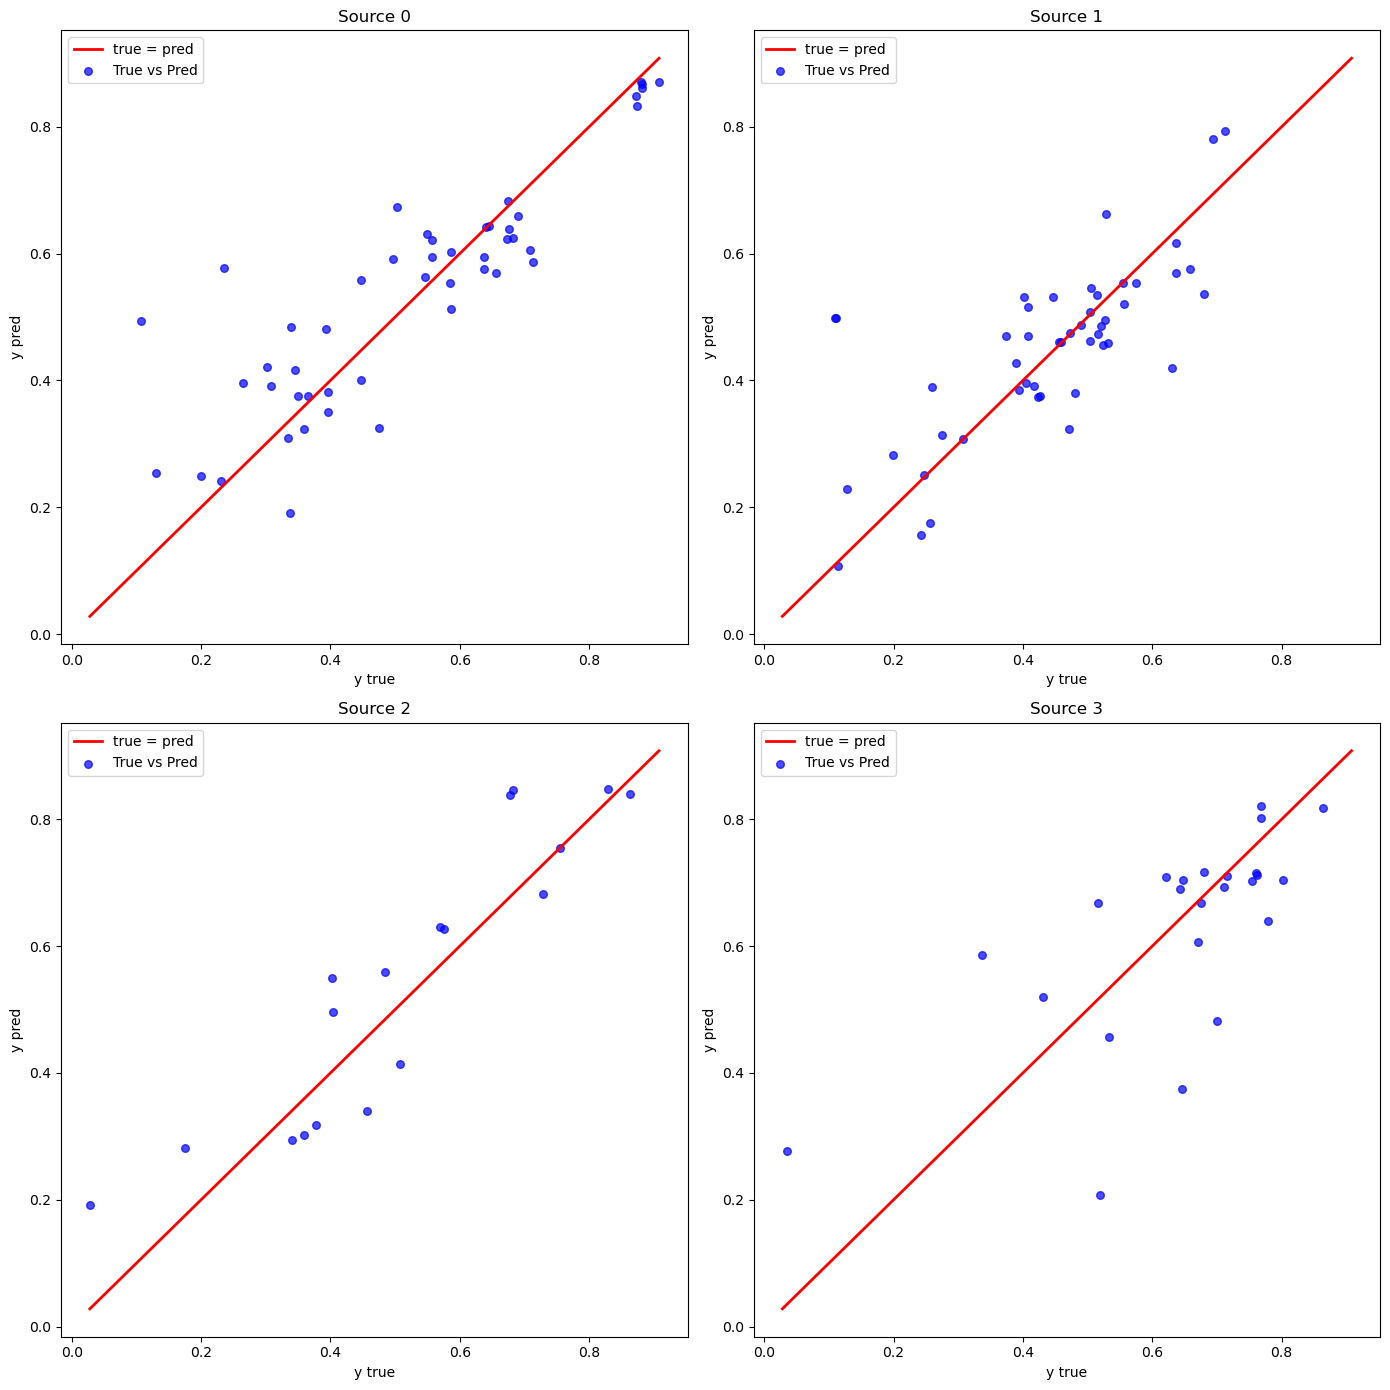

In [8]:
# Visualize true-pred plot
fig_true_pred = plotting.plot_true_pred(
    model=model,
    test_dataset=test_dataset,
    device=device,
    batch_size=32
)
plt.show()

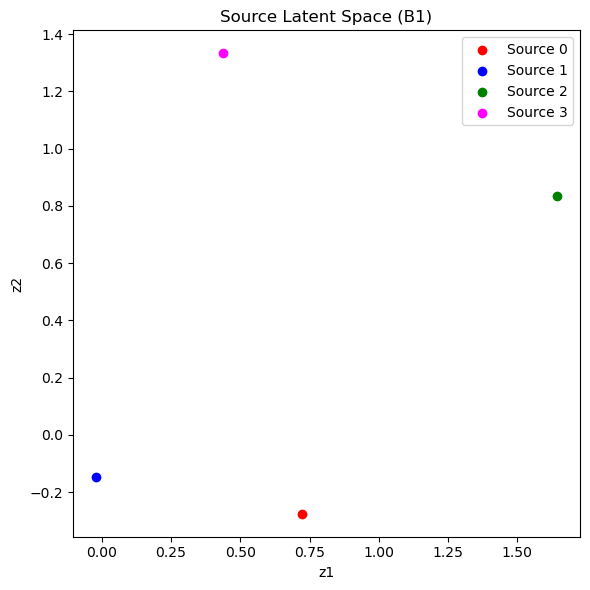

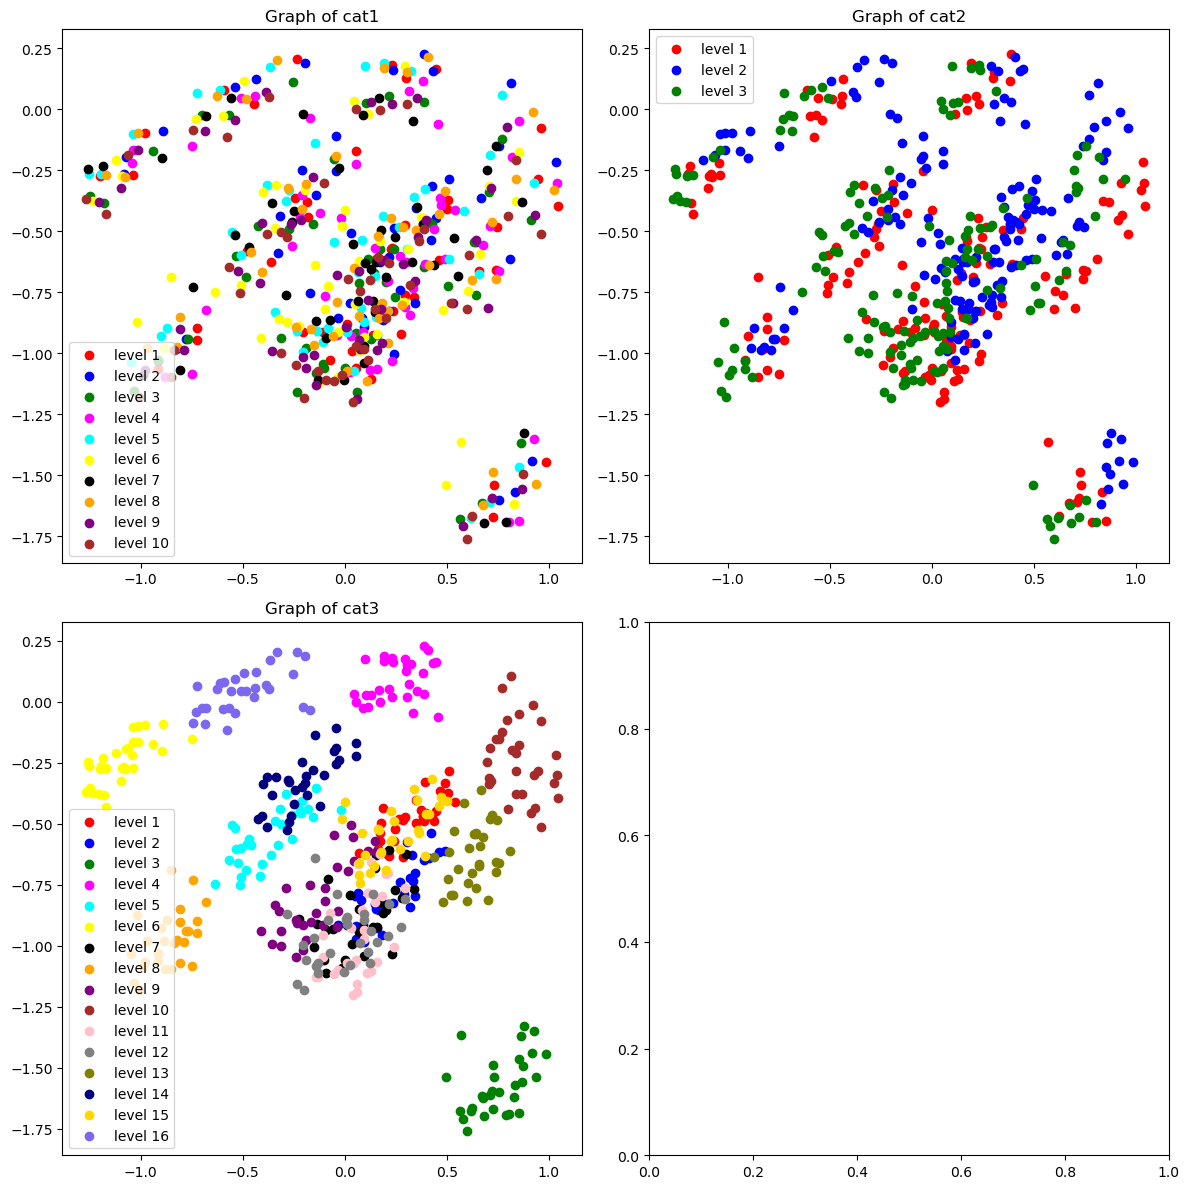

In [9]:
# Visualize latent space
# For HOIP, we can visualize both source latent space (B1) and categorical latent space (B2)
# Source latent space
fig_latent_b1 = plotting.plot_2D_latent_space(
    model=model,
    block_idx=0,  # Source latent space (B1)
    dcat=train_dataset.meta.get('dcat', []),
    device=device,
    figsize=6,
    num_iterations=100
)
plt.show()

# Categorical latent space (B2) - if categorical inputs exist
if train_dataset.meta['qual_in']:
    fig_latent_b2 = plotting.plot_2D_latent_space(
        model=model,
        block_idx=1,  # Categorical latent space (B2)
        dcat=train_dataset.meta.get('dcat', []),
        device=device,
        figsize=6,
        num_iterations=100
    )
    plt.show()